# Explorando o modelo Faster R-CNN

Neste notebook será tentado treinar o modelo "Faster R-CNN" na base de dados NuScenes para detecção de VRUs.

## Links interessantes

As referências abaixo foram utilizadas como base para escrever este notebook

**Artigo original do modelo**

- [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)

**Implementação do modelo no PyTorch**

- [Possíveis implementações do modelo](https://pytorch.org/vision/main/models/faster_rcnn.html)
- [Implementação do modelo proposto no paper original](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn)

**Tutoriais para treinamento do modelo pelo PyTorch**

- [PyTorch: Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [A Simple Pipeline to Train PyTorch Faster RCNN Object Detection Model](https://debuggercafe.com/a-simple-pipeline-to-train-pytorch-faster-rcnn-object-detection-model/)
- [Custom Object Detection using PyTorch Faster RCNN](https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/)

**Código 3D para 2D nuScenes**

- [Notebook com funções importantes para transformação](https://github.com/asvath/mobile_robotics/blob/master/nuscenes%20extract%20and%20write%20out%202d%20annotation%20boxes-revised%20to%20truncate%20bb.ipynb)

## Instalando bibliotecas necessárias

In [1]:
%pip install opencv-python==4.5.4.58 --quiet
%pip install nuscenes-devkit --quiet
%pip install torch torchvision --quiet

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


## Importando bibliotecas

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility

import os

## Definindo variáveis/constantes iniciais

In [3]:
data_path = '../../data'  # Caminho até o diretório onde os dados da nuscenes estão
nusc = NuScenes(version='v1.0-mini', dataroot=data_path, verbose=True)  # Carrega o dataset

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.641 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Fazendo inferências iniciais

Antes de tentar treinar o modelo de forma customizada, vamos tentar utilizá-lo para prever os *bounding boxes* a partir do seu treinamento prévio em outra base (COCO).

### Definindo uma função para visualização de imagens

Seguindo a documentação do [PyTorch para visualização de dados](https://pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#visualization-utilities), a função abaixo será utilizada para visualizar algumas imagens

In [4]:
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Lendo algumas imagens da base de dados

In [5]:
def load_nuscenes_image(sample_num):
    '''
    Carrega a imagem da câmera frontal do sample `sample_num`
    '''
    sample_data = nusc.get('sample_data', nusc.sample[sample_num]['data']['CAM_FRONT'])
    image_path = os.path.join(data_path, sample_data['filename'])
    image = read_image(image_path)
    return sample_data, image

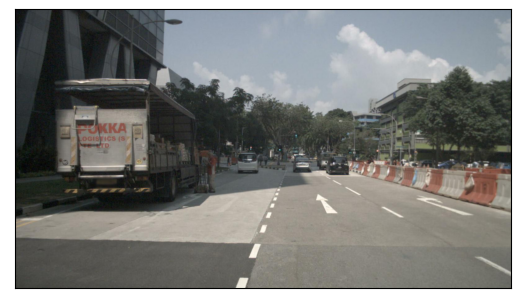

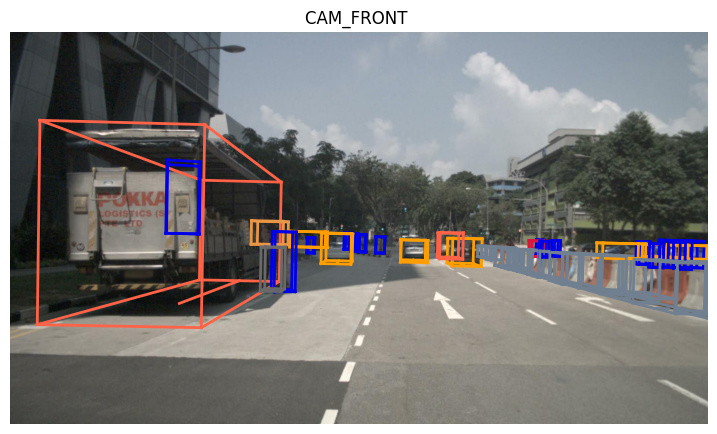

In [6]:
sample_data_1, image_1 = load_nuscenes_image(0)

show(image_1)
nusc.render_sample_data(sample_data_1['token'])

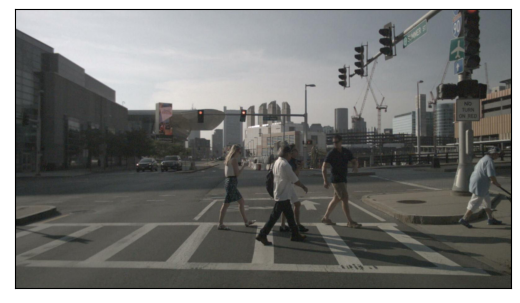

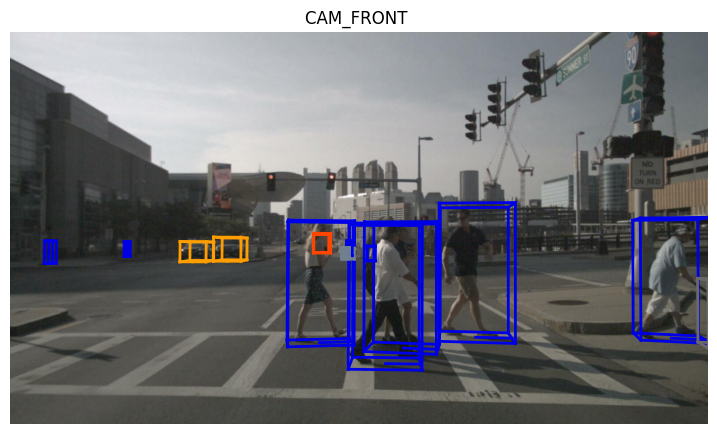

In [7]:
sample_data_2, image_2 = load_nuscenes_image(110)

show(image_2)
nusc.render_sample_data(sample_data_2['token'])

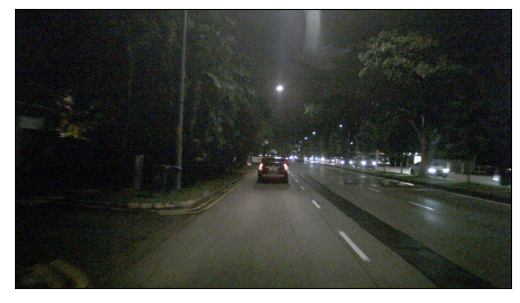

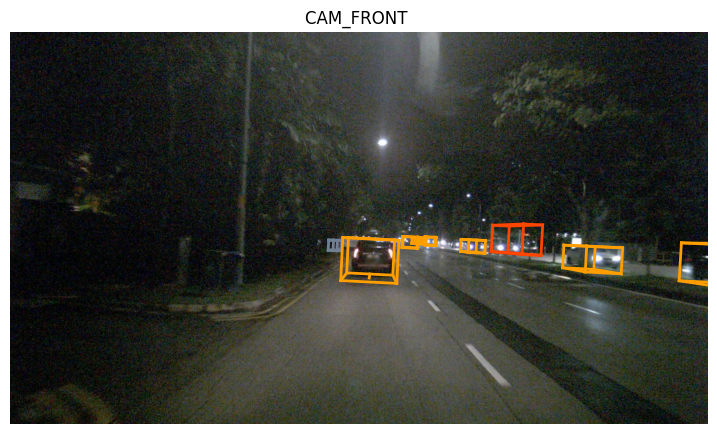

In [8]:
sample_data_3, image_3 = load_nuscenes_image(300)

show(image_3)
nusc.render_sample_data(sample_data_3['token'])

In [9]:
images_list = [image_1, image_2, image_3]

### Chamando o modelo para fazer inferências

In [10]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(img) for img in images_list]

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model(images)

In [11]:
outputs[0]

{'boxes': tensor([[1004.5426,  473.7062, 1077.9147,  535.6048],
         [ 895.9669,  484.5670,  957.2006,  526.2607],
         [ 128.0992,  228.4456,  580.8445,  622.8684],
         [ 715.4121,  461.8282,  785.4109,  529.8926],
         [ 848.1904,  441.3726,  861.5165,  460.6853],
         [1359.8837,  483.7835, 1433.7493,  515.7043],
         [ 977.0119,  460.9887, 1032.1432,  514.2782],
         [ 783.0012,  466.1099,  800.2049,  510.7472],
         [ 898.7395,  473.1881,  948.1938,  496.4375],
         [ 594.1984,  446.6861,  653.2457,  593.1301],
         [1191.3376,  481.9468, 1205.5199,  502.9745],
         [1304.9099,  484.7146, 1355.2510,  510.0120],
         [1089.8813,  496.9341, 1109.6200,  526.2533],
         [1074.6544,  450.3471, 1085.3992,  467.0462],
         [1218.4092,  484.6354, 1232.3905,  504.7285],
         [ 756.1783,  442.0797,  763.5083,  456.9756],
         [ 799.5081,  470.2917,  815.2345,  509.3708],
         [ 753.4243,  441.0593,  765.2048,  459.7457],
 

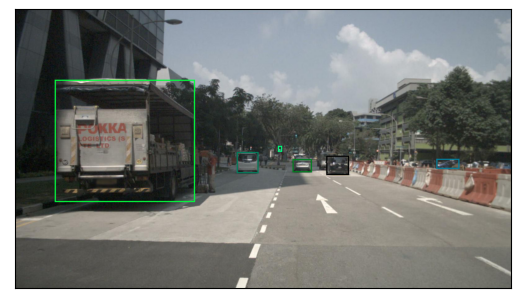

In [12]:
score_threshold = .8
img_1_with_boxes = draw_bounding_boxes(image_1, boxes=outputs[0]['boxes'][outputs[0]['scores'] > score_threshold], width=4)
show(img_1_with_boxes)

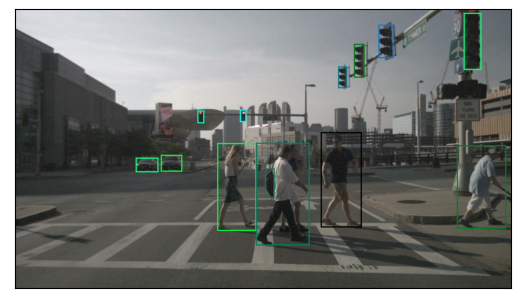

In [13]:
score_threshold = .8
img_2_with_boxes = draw_bounding_boxes(image_2, boxes=outputs[1]['boxes'][outputs[1]['scores'] > score_threshold], width=4)
show(img_2_with_boxes)

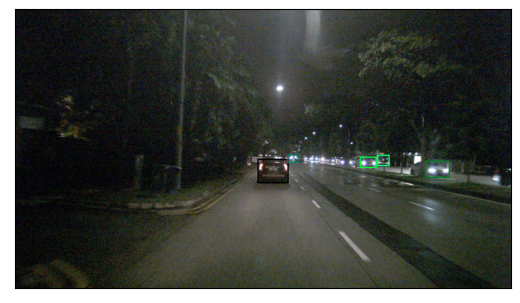

In [14]:
score_threshold = .8
img_3_with_boxes = draw_bounding_boxes(image_3, boxes=outputs[2]['boxes'][outputs[2]['scores'] > score_threshold], width=4)
show(img_3_with_boxes)

In [15]:
def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ANY, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data(single image).
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token(image token).
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    #this is for a single sample image
    return data_path, box_list, ann_list, cam_intrinsic #single image info

In [22]:
def threeD_2_twoD(boxsy, intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    
    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)
    
    return min_x, min_y, max_x, max_y

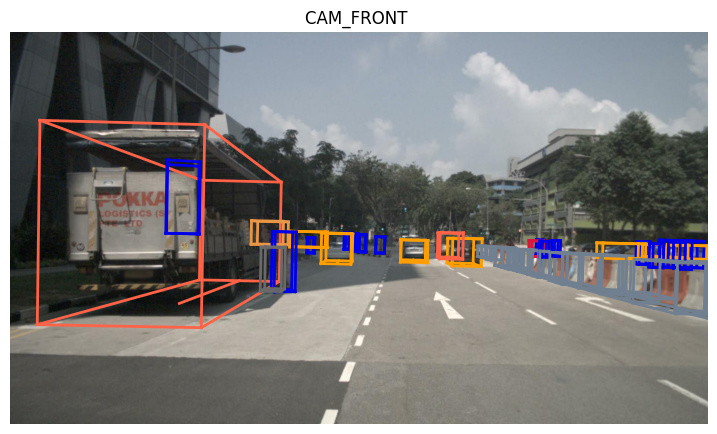

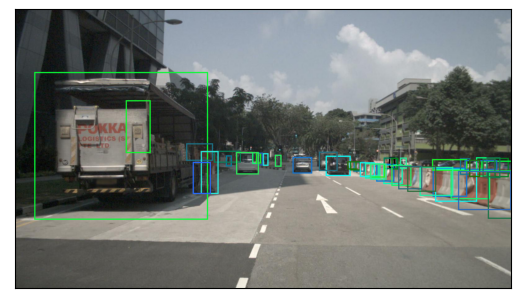

In [26]:
nusc.render_sample_data(nusc.sample[0]['data']['CAM_FRONT'])

path, boxes, anns, intrinsic_matrix = get_sample_data(nusc, nusc.sample[0]['data']['CAM_FRONT'])
boxes_2d = [threeD_2_twoD(box, intrinsic_matrix) for box in boxes]
boxes_2d = torch.tensor(boxes_2d)

img_1_with_boxes_2d = draw_bounding_boxes(image_1, boxes=boxes_2d, width=4)
show(img_1_with_boxes_2d)